Importations et montage Google Drive

In [73]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
import random

import tensorflow as tf
import keras

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from IPython.display import display
%matplotlib inline


drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Création du dataset

In [74]:
# Fonction pour obtenir les chemins des images et leurs étiquettes
def get_image_paths_and_labels(directory):
    file_paths = []
    name_labels = []
    labels = []

    # Parcours des sous-répertoires
    for subdir, _, files in os.walk(directory):
        for file in files:
            # Construction du chemin complet de l'image
            file_path = os.path.join(subdir, file)
            # Obtention du nom de l'image
            name = os.path.splitext(file)[0]
            # Extraction de la partie principale du nom de l'image (sans l'extension)
            name_label = name.split('-')[0]
            # Détermination de l'étiquette
            if name_label == 'Normal':
                label = 0
            else:
                label = 1
            # Ajout des informations au DataFrame
            file_paths.append(file_path)
            name_labels.append(name_label)
            labels.append(label)

    # Création du DataFrame
    df = pd.DataFrame({'file_path': file_paths, 'name_label': name_labels, 'label': labels})

    return df

# Chemins des dossiers "Sain" et "Malade"
healthy_folder = os.path.join('/content/drive/MyDrive/Test_Modelo/Sain')
sick_folder = os.path.join('/content/drive/MyDrive/Test_Modelo/Malade')

# Obtenir les chemins des images et leurs étiquettes pour chaque dossier
healthy_df = get_image_paths_and_labels(healthy_folder)
sick_df = get_image_paths_and_labels(sick_folder)

# Concaténer les DataFrames pour obtenir un seul DataFrame
full_df = pd.concat([healthy_df, sick_df], ignore_index=True)



In [75]:
unique_values = full_df.groupby('name_label')['label'].unique()
print(unique_values)

name_label
COVID              [1]
Lung_Opacity       [1]
Normal             [0]
Viral_Pneumonia    [1]
Name: label, dtype: object


In [76]:
print(full_df.shape)
full_df.head()

(1200, 3)


,file_path,name_label,label
0,/content/drive/MyDrive/Test_Modelo/Sain/Normal...,Normal,0
1,/content/drive/MyDrive/Test_Modelo/Sain/Normal...,Normal,0
2,/content/drive/MyDrive/Test_Modelo/Sain/Normal...,Normal,0
3,/content/drive/MyDrive/Test_Modelo/Sain/Normal...,Normal,0
4,/content/drive/MyDrive/Test_Modelo/Sain/Normal...,Normal,0


Affichage d'une image

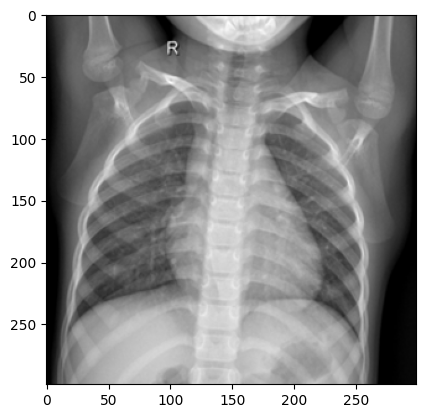

In [77]:
# Chemin de l'image
filepath =full_df.file_path[0]

# Lecture du fichier
im = tf.io.read_file(filepath)

# On décode le fichier
im = tf.image.decode_jpeg(im, channels=3)

# Affichage du tensor
plt.imshow(im);


Création des sets de test et d'entraînement

In [78]:
X_train_path, X_test_path, y_train, y_test = train_test_split(full_df.file_path, full_df.label, train_size=0.8, random_state=1234)

X_test = []
for filepath in tqdm(X_test_path):
    # Lecture du fichier
    im = tf.io.read_file(filepath)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    # Redimensionnement
    im = tf.image.resize(im, size=(224, 224))
    X_test.append([im])

X_test = tf.concat(X_test, axis=0)

100%|██████████| 240/240 [00:06<00:00, 35.27it/s] 


Chargement du modèle VGG16 tuné et pré-entraîné, prédictions et métriques

In [79]:

# Charger le modèle entraîné
model = load_model('/content/drive/MyDrive/BC_DS/Pretraines_models/PT_Models_Nikolai/Modèles_finaux/VGG16_finetuned_model.h5')


In [80]:
# Effectuer des prédictions sur un ensemble de données de validation ou de test
y_pred = model.predict(X_test)



8/8 [==============================] - 148s 18s/step


In [81]:


# Convertir les prédictions en classes binaires (0 ou 1)
y_pred_binary = (y_pred > 0.5).astype(int)


# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_binary)


print("Matrice de confusion", conf_matrix)

Matrice de confusion [[112   2]
 [  5 121]]


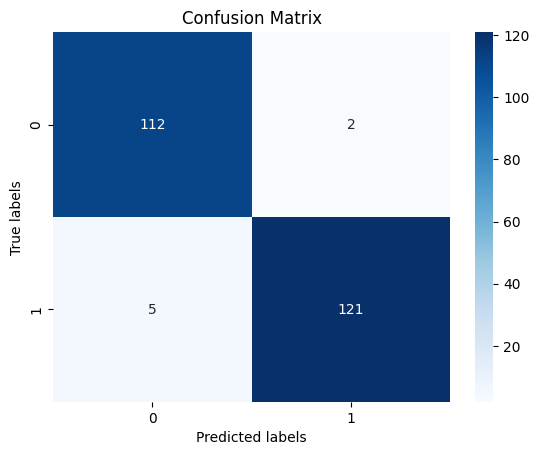

In [82]:
# Afficher la matrice de confusion sous forme de heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [83]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       114
           1       0.98      0.96      0.97       126

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240



Grad-Cam : initialisation pour le modèle VGG16 et fonctions

In [84]:
model_builder = keras.applications.xception.Xception
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block5_conv3"




In [85]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=img_size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image.open(cam_path))

On créé une liste avec 20 chemins d'images malades et saines à la suite

In [86]:
# Sélectionner les 2 premières images de chaque classe
covid_paths = full_df[full_df['name_label'] == 'COVID']['file_path'].tolist()[:2]
lung_opacity_paths = full_df[full_df['name_label'] == 'Lung_Opacity']['file_path'].tolist()[:2]
viral_pneumonia_paths = full_df[full_df['name_label'] == 'Viral_Pneumonia']['file_path'].tolist()[:2]

# Sélectionner toutes les images de la classe "Normal"
normal_paths = full_df[full_df['name_label'] == 'Normal']['file_path'].tolist()

# Mélanger les chemins d'images de la classe "Normal"
random.shuffle(normal_paths)

# Sélectionner les 2 premières images mélangées
normal_paths_selected = normal_paths[:2]

# Sélectionner aléatoirement 2 autres images mélangées
normal_paths_selected += random.sample(normal_paths[2:], 2)

# Sélectionner aléatoirement 2 autres images mélangées
normal_paths_selected += random.sample(normal_paths[4:], 2)

# Créer list_of_image_paths en alternant entre les chemins d'images de chaque classe
list_of_image_paths = []
for i in range(2):
    list_of_image_paths.extend([covid_paths[i], normal_paths_selected[i], lung_opacity_paths[i], normal_paths_selected[i+2], viral_pneumonia_paths[i], normal_paths_selected[i+4]])


In [87]:
#On ajoute quelques images ciblées à cette liste
new_images_paths = [
    '/content/drive/MyDrive/BC_DS/COVID-19_Radiography_Dataset/COVID/images/COVID-231.png',
    '/content/drive/MyDrive/BC_DS/COVID-19_Radiography_Dataset/Normal/images/Normal-1489.png',
    '/content/drive/MyDrive/BC_DS/COVID-19_Radiography_Dataset/COVID/images/COVID-1525.png',
    '/content/drive/MyDrive/BC_DS/COVID-19_Radiography_Dataset/Normal/images/Normal-260.png',
    '/content/drive/MyDrive/BC_DS/COVID-19_Radiography_Dataset/Viral_Pneumonia/images/Viral Pneumonia-15.png',
    '/content/drive/MyDrive/BC_DS/COVID-19_Radiography_Dataset/Normal/images/Normal-226.png',
    '/content/drive/MyDrive/BC_DS/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-408.png',
    '/content/drive/MyDrive/BC_DS/COVID-19_Radiography_Dataset/Normal/images/Normal-224.png'
]

# Ajouter les nouvelles images à la liste existante
list_of_image_paths.extend(new_images_paths)

In [88]:
list_of_image_paths

['/content/drive/MyDrive/Test_Modelo/Malade/COVID-84.png',
 '/content/drive/MyDrive/Test_Modelo/Sain/Normal-483.png',
 '/content/drive/MyDrive/Test_Modelo/Malade/Lung_Opacity-240.png',
 '/content/drive/MyDrive/Test_Modelo/Sain/Normal-450.png',
 '/content/drive/MyDrive/Test_Modelo/Malade/Viral_Pneumonia-84.png',
 '/content/drive/MyDrive/Test_Modelo/Sain/Normal-240.png',
 '/content/drive/MyDrive/Test_Modelo/Malade/COVID-115.png',
 '/content/drive/MyDrive/Test_Modelo/Sain/Normal-178.png',
 '/content/drive/MyDrive/Test_Modelo/Malade/Lung_Opacity-62.png',
 '/content/drive/MyDrive/Test_Modelo/Sain/Normal-473.png',
 '/content/drive/MyDrive/Test_Modelo/Malade/Viral_Pneumonia-246.png',
 '/content/drive/MyDrive/Test_Modelo/Sain/Normal-330.png',
 '/content/drive/MyDrive/BC_DS/COVID-19_Radiography_Dataset/COVID/images/COVID-231.png',
 '/content/drive/MyDrive/BC_DS/COVID-19_Radiography_Dataset/Normal/images/Normal-1489.png',
 '/content/drive/MyDrive/BC_DS/COVID-19_Radiography_Dataset/COVID/images/C

Préprocessing bref de ces images et enregistrement dans un set d'évaluation

In [89]:
X_eval = []
for img_path in list_of_image_paths:
    # Lecture du fichier
    im = tf.io.read_file(img_path)
    # On décode le fichier
    im = tf.image.decode_jpeg(im, channels=3)
    # Redimensionnement
    im = tf.image.resize(im, size=(224, 224))
    X_eval.append([im])

X_eval = tf.concat(X_eval, axis=0)
print(X_eval.shape)


(20, 224, 224, 3)


Predictions avec notre modèle de ces images

In [90]:
# Chargement du modèle et désactivation dernière couche
model = model
model.layers[-1].activation = None

# Obtenir les prédictions du modèle
preds = model.predict(X_eval)

# Interpréter les prédictions pour obtenir les classes prédites
predictions = (preds > 0.5).astype(int)

# Afficher les prédictions
print(predictions)

1/1 [==============================] - 13s 13s/step
[[1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]]


On enregistre dans une liste results les résultats de GRAD-CAM

In [91]:
# Liste pour stocker les résultats avec le nom de fichier associé
results = []

for img_path in list_of_image_paths:
    # Obtenez le nom de fichier à partir du chemin complet
    file_name = os.path.basename(img_path)

    # Obtenez le tableau d'image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Générez la carte de chaleur Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Sauvegardez Grad-CAM avec le nom de fichier associé
    cam_path = f"gradcam_{file_name}"
    save_and_display_gradcam(img_path, heatmap, cam_path)

    # Ajoutez le résultat à la liste
    results.append((file_name, cam_path))



Output hidden; open in https://colab.research.google.com to view.

On affiche les GRAD-CAM avec le nom de l'image et la classe prédite par notre modèle

In [92]:
# Convertir predictions en une liste de valeurs uniques
predictions_list = predictions.flatten().tolist()

# Fusionner les listes results et predictions_list
results_with_predictions = [(file_name, cam_path, prediction) for (file_name, cam_path), prediction in zip(results, predictions_list)]

# Nombre d'images à afficher par paire
num_images = len(results_with_predictions)
num_pairs = num_images // 2

# Créer une figure avec des sous-graphiques
fig, axs = plt.subplots(num_pairs, 2, figsize=(15, 7*num_pairs))

# Parcourir les paires d'images
for i in range(num_pairs):
    for j in range(2):
        idx = i * 2 + j
        if idx < num_images:
            file_name, cam_path, prediction = results_with_predictions[idx]

            # Charger l'image Grad-CAM
            img = Image.open(cam_path)

            # Afficher l'image
            axs[i, j].imshow(img)
            axs[i, j].set_title(f'{file_name}\nPredicted Class: {prediction}')
            axs[i, j].axis('off')

# Afficher la figure
plt.tight_layout()
plt.show()



Output hidden; open in https://colab.research.google.com to view.